# Описание данных
В данной работе используется база ЭКГ сигналов [PTB-XL](https://physionet.org/content/ptb-xl/1.0.1/), содержащая 21837 записей необработанных сигналов электрокардиограмм. Каждая запись содержит 12 сигналов с разных отведений, 10 секунд каждый. Записи в двух разрешениях - 100Гц и 500Гц. Также имеется описание данных, содержащее некоторую информацию о пациенте, условий получения ЭКГ и заключение врача. Заключение врача описывается в виде подробного диагноза и не поддается простому разбиению на классы, однако согласно описанию данных, каждой записи были присвоены специальные метки, верифицированные двумя кардиологами.
Датасет содержит 44 класса диагнозов, агрегированных в 5 суперклассов:
- NORM - Normal ECG
- MI - Myocardial Infarction
- STTC - ST/T change
- CD - Conduction Disturbance
- HYP - Hypertrophy

Классы пересекаются между собой

Описание задачи
=========

Необходимо по ЭКГ определить наличие каждого из 5 классов:
- NORM - Normal ECG
- MI - Myocardial Infarction
- STTC - ST/T change
- CD - Conduction Disturbance
- HYP - Hypertrophy

# Описание реализации

Вместо того, чтобы использовать в алгоритмах необработанные сигналы ЭКГ, я выделил из данных макрохарактеристики. Для чтения и перевода в вид массива ЭКГ сигналов использовалась библиотека wfdb(waveform-database)

Для сегментации была использована специально обученная на фреймворке pytorch нейросеть. Результаты сегментации были записаны в формате json в виде:
- начало волны (в единицах сигнала)
- конец волны (в единицах сигнала)
- тип волны (p, qrs, t или none)

В качестве макрохарактеристик из описания данных были вхзяты:
- SEX - пол (из описания данных, содежит пропущенные значения)
- AGE - возраст (из описания данных, содержит пропущенные значения)
- HEIGHT - рост (из описания данных, содержит пропущенные значения)
- WEIGHT - вес (из описания данных, содержит пропущенные значения)

Из сегментации сигнала с каждого из отведений были выделены следующие признаки:
- HR - heart rate, пульс, считался через количество qrs комплексов / длину записи
- P_AV - средняя длина p волны (мс)
- P_DEV - среднеквадратичное отклонение длины p волны (мс)
- P_A_AV - средняя амплитуда p волны
- P_A_DEV - среднеквадратичное отклонение амплитуды волны
- QRS_AV - средняя длина qrs комплекса (мс)
- QRS_DEV - среднеквадратичное отклонение длины qrs комплекса (мс)
- QRS_A_AV - средняя амплитуда qrs комплекса
- QRS_A_DEV - среднеквадратичное отклонение амплитуды qrs комплекса
- T_AV - cредняя длина t волны (мс)
- T_DEV - cреднеквадратичное отклонение длины t волны (мс)
- T_A_AV - средняя амплитуда t волны
- T_A_DEV - среднеквадратичное отклонение амплитуды t волны
- PR_INT_AV - cредняя длина pr интервала (мс)
- PR_INT_DEV - cреднеквадратичное отклонение длины pr интервала (мс)
- PR_SEGM_AV - cредняя длина pr сегмента (мс)
- PR_SEGM_DEV - cреднеквадратичное отклонение длины pr сегмента (мс)
- ST_SEGM_AV - cредняя длина st сегмента (мс)
- ST_SEGM_DEV - cреднеквадратичное отклонение длины st сегмента (мс)
- QT_INT_AV - cредняя длина qt интервала (мс)
- QT_INT_DEV - cреднеквадратичное отклонение длины qt интервала (мс)
- QRSA_AV - средняя площадь QRS сегмента, где площадь QRS = width * height * 0.5
- QRSA_DEV - среднеквадратичное отклонение площади QRS сегмента, где площадь QRS = width * height * 0.5
- QRSTA_AV = средняя площадь QRST сегмента, где площадь QRST =  QRSA + 0.5 * width_of_T * height_of_T
- QRSTA_DEV = среднеквадратичное отклонение площади QRST сегмента, где площадь QRST =  QRSA + 0.5 * width_of_T * height_of_T

Итого 4 признака из описания данных, 25 признаков на каждый из 12 сигналов и 25 - средние значения по всем сигналам. Всего 329 признаков

Кроме того данные после обработки содержат 10 столбцов-классов (5 показывают, относится ли данная запись к какому-либо из классов, а еще 5 содержат вероятность принадлежности (но не вероятность того, что запись не принадлежит классу)):

# Реализация задачи

## Получение данных

Код для скачивания и распаковки PTB-XL:

In [ ]:
# Code for download database
# Requires urllib package

import os
import urllib.request
from zipfile import ZipFile

DOWNLOAD_URL = "https://storage.googleapis.com/ptb-xl-1.0.1.physionet.org/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip"
ZIP_FILE_NAME = 'PTB_XL.zip'

def fetch_and_extractPTB_XL_Data(data_url = DOWNLOAD_URL):
    zip_path = os.path.join(ZIP_FILE_NAME)
    urllib.request.urlretrieve(data_url, zip_path)
    with ZipFile(ZIP_FILE_NAME, 'r') as zfile:
        zfile.extractall(SAVE_PATH)
    os.remove(ZIP_FILE_NAME)

fetch_and_extractPTB_XL_Data()

## Сегментация данных

Далее воспользуемся натренированной на pytorch нейронной сетью для сегментации сигналов на p, qrs и t сегменты.
Скрипт, используемый мною для сегментации (пути до модели и до базы данных задаются через глобальные переменные вручную, результат сохраняется в виде формата json там же, где лежат сами сигналы):

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import wfdb
from ipywidgets import IntProgress
from IPython.display import display

ecg_signal_len = 5000
sample_rate = 500
border = int(0.8 * sample_rate)
path_to_model = "Segmentation_model/"
path_to_data = "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"

class Delineation:
    def __init__(self):
        self._model = torch.jit.load(path_to_model + "model.pt")
        self._max_dist = int(0.03 * sample_rate)
        self._border = border
        
    def _remove_small(self, signal):
        last_zero = 0
        for i in range(len(signal)):
            if signal[i] == 0:
                if i - last_zero < self._max_dist:
                    signal[last_zero:i] = 0
                last_zero = i

    def _merge_small(self, signal):
        lasts = np.full(signal.max() + 1, -(self._max_dist+1))
        for i in range(len(signal)):
            m = signal[i]
            if i - lasts[m] < self._max_dist and m > 0:
                signal[lasts[m]:i] = m
            lasts[m] = i

    def _mask_to_delineation(self, data):
        masks = np.argmax(data, 1)
        delineation = []
        v_to_del = {0:'none', 1:'p', 2:'qrs', 3:'t'}
        for rec in masks:
            self._merge_small(rec)
            self._remove_small(rec)
            rec_del = []
            i = 0
            rec_len = len(rec)
            while i < rec_len:
                v = rec[i]
                if v > 0:
                    rec_del.append({
                        "begin": i,
                        "end": 0,
                        "type": v_to_del[v]
                    })
                    while i < rec_len and rec[i] == v:
                        rec_del[-1]["end"] = i
                        i += 1
                    t = rec_del[-1]
                    if t["begin"] < self._border or t["end"] > rec_len - self._border:
                        rec_del.pop()
                i += 1
            d_res = []
            for c, n in zip(rec_del[:-1], rec_del[1:]):
                d_res.append(c)
                d_res.append({
                    "begin": c["end"],
                    "end": n["begin"],
                    "type": "none"
                })
            if rec_del:
                begin = {
                    "begin": 0,
                    "end": rec_del[0]["begin"],
                    "type": "none"
                }
                end = {
                    "begin": rec_del[-1]["end"],
                    "end": rec_len,
                    "type": "none"
                }
                d_res = [begin] + d_res + [rec_del[-1], end]
            else:
                d_res.append({
                    "begin": 0,
                    "end": rec_len,
                    "type": "none"
                })
            delineation.append(d_res)
        return delineation

    def __call__(self, signal):
        signal = torch.FloatTensor(np.expand_dims(signal, axis=1))
        masks = self._model(signal).data.numpy()
        return self._mask_to_delineation(masks)

def main():
    database_info = pd.read_csv(path_to_data + 'ptbxl_database.csv', index_col='ecg_id')
    progress = IntProgress(min=0, max=len(database_info.index), value=0)
    display(progress)
    delineation = Delineation()
    for f in database_info.filename_hr:
        signal, meta = wfdb.rdsamp(path_to_data+f)
        data = np.array(signal)
        data_transp = np.transpose(data)
        result = delineation(data_transp)
        with open(path_to_data + f + ".json", "w") as write_file:
            json.dump(result, write_file)
        progress.value += 1

if __name__ == "__main__":
    main()

## Выделение макрохарактеристик

После сегментации необходимо выделить перечисленные в описании реализации характеристики

In [1]:
import pandas as pd

Создадим DataFrame для итогового результата:

In [2]:
ch_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
attr_names = ['HR', 'P_AV', 'P_DEV', 'P_A_AV', 'P_A_DEV', 'QRS_AV', 'QRS_DEV', 'QRS_A_AV', 'QRS_A_DEV', 'T_AV', 'T_DEV', 'T_A_AV', 'T_A_DEV', 'PR_INT_AV', 'PR_INT_DEV', 'PR_SEGM_AV', 'PR_SEGM_DEV', 'ST_SEGM_AV',  'ST_SEGM_DEV', 
    'QT_INT_AV', 'QT_INT_DEV', 'QRSA_AV', 'QRSA_DEV', 'QRSTA_AV', 'QRSTA_DEV']
attributes = ["SEX", "AGE", "HEIGHT", "WEIGHT"] + ['ALL_C_' + attr_name for attr_name in attr_names] + [ch_name + '_C_' + attr_name for ch_name in ch_names for attr_name in attr_names]

macro_data = pd.DataFrame(columns=attributes)
macro_data

,SEX,AGE,HEIGHT,WEIGHT,ALL_C_HR,ALL_C_P_AV,ALL_C_P_DEV,ALL_C_P_A_AV,ALL_C_P_A_DEV,ALL_C_QRS_AV,...,V6_C_PR_SEGM_AV,V6_C_PR_SEGM_DEV,V6_C_ST_SEGM_AV,V6_C_ST_SEGM_DEV,V6_C_QT_INT_AV,V6_C_QT_INT_DEV,V6_C_QRSA_AV,V6_C_QRSA_DEV,V6_C_QRSTA_AV,V6_C_QRSTA_DEV


Для начала рассмотрим описание данных

In [3]:
path_to_data = "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
database_info = pd.read_csv(path_to_data+'ptbxl_database.csv', index_col='ecg_id')
database_info

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


Добавим из него в итоговые данные пол, возраст, рост и вес:

In [4]:
macro_data.SEX = database_info.sex
macro_data.AGE = database_info.age
macro_data.HEIGHT = database_info.height
macro_data.WEIGHT = database_info.weight
macro_data

,SEX,AGE,HEIGHT,WEIGHT,ALL_C_HR,ALL_C_P_AV,ALL_C_P_DEV,ALL_C_P_A_AV,ALL_C_P_A_DEV,ALL_C_QRS_AV,...,V6_C_PR_SEGM_AV,V6_C_PR_SEGM_DEV,V6_C_ST_SEGM_AV,V6_C_ST_SEGM_DEV,V6_C_QT_INT_AV,V6_C_QT_INT_DEV,V6_C_QRSA_AV,V6_C_QRSA_DEV,V6_C_QRSTA_AV,V6_C_QRSTA_DEV
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,1,56.0,NaN,63.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,19.0,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,37.0,NaN,69.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,24.0,NaN,82.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,19.0,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,1,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21834,0,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21835,1,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проверим пропущенные значения в новых признаках

In [6]:
print("{}%".format(macro_data['SEX'].isna().sum() / len(macro_data) * 100))
print("{}%".format(macro_data['AGE'].isna().sum() / len(macro_data) * 100))
print("{}%".format(macro_data['HEIGHT'].isna().sum() / len(macro_data) * 100))
print("{}%".format(macro_data['WEIGHT'].isna().sum() / len(macro_data) * 100))

0.0%
0.40756514173192293%
68.02216421669644%
56.820991894491%


Выделим длины волн и среднеквадратичные отклонения:

In [ ]:
import json
import numpy as np

# Библиотеки для полоски прогресса, нужен в связи с долгим выполнением
from ipywidgets import IntProgress
from IPython.display import display

progress = IntProgress(min=0, max=len(macro_data.index), value=0)
display(progress)
#attr_lists = {'p_mean':[], 'p_std':[], 'qrs_mean':[], 'qrs_std':[], 't_mean':[], 't_std'}
for i, record in enumerate(database_info.iloc):
    record_data = json.load(open(path_to_data + record.filename_hr + ".json", 'r'))
    template_dict = {'P':[], 'QRS':[], 'T':[], 'PR_INT':[], 'PR_SEGM': [], 'ST_SEGM':[], 'QT_INT':[]}
    all_lens = template_dict.copy()
    ecg_all_len = 0
    for ch_num, chanel in enumerate(record_data):
        # Словарь длин для одного канала
        ch_lens = template_dict.copy()
        # Длина всей записи для вычисления пульса
        for wave_num, wave in enumerate(chanel):
            if wave['type'] == 'p':
                # Собираем длины p волн в список
                ch_lens['P'].append(wave['end'] - wave['begin'])
                # Собираем длины pr интервалов и pr сегментов
                if wave_num < len(chanel) - 2:
                    if (chanel[wave_num + 1]['type'] == 'qrs'):
                        ch_lens['PR_INT'].append(chanel[wave_num + 1]['begin'] - wave['begin'])
                        ch_lens['PR_SEGM'].append(0)
                    if (chanel[wave_num + 2]['type'] == 'qrs'):
                        ch_lens['PR_INT'].append(chanel[wave_num + 2]['begin'] - wave['begin'])
                        ch_lens['PR_SEGM'].append(chanel[wave_num + 2]['begin'] - wave['end'])
            if wave['type'] == 'qrs':
                # Собираем длины qrs комплексов в список
                ch_lens['QRS'].append(wave['end'] - wave['begin'])
                # Собираем длины st сегментов и qt интервалов
                if wave_num < len(chanel) - 2:
                    if (chanel[wave_num + 1]['type'] == 't'):
                        ch_lens['QT_INT'].append(chanel[wave_num + 1]['end'] - wave['begin'])
                        ch_lens['ST_SEGM'].append(0)
                    if (chanel[wave_num + 2]['type'] == 't'):
                        ch_lens['QT_INT'].append(chanel[wave_num + 2]['end'] - wave['begin'])
                        ch_lens['ST_SEGM'].append(chanel[wave_num + 2]['begin'] - wave['end'])
            if wave['type'] == 't':
                # Собираем длины t волн
                ch_lens['T'].append(wave['end'] - wave['begin'])


        # Добавляем средние значения и дисперсии в итоговые данные
        for key in ch_lens:
            all_lens[key].extend(ch_lens[key])
            mean = 0
            std = 0
            if len(ch_lens[key]) > 0:
                mean = np.mean(ch_lens[key])
                std = np.std(ch_lens[key])
            macro_data.loc[macro_data.index[i], ch_names[ch_num] + '_C_' + key + '_AV'] = mean * 1000 / sample_rate
            macro_data.loc[macro_data.index[i], ch_names[ch_num] + '_C_' + key + '_DEV'] = std * 1000 / sample_rate
    for key in all_lens:
        mean = 0
        std = 0
        if len(all_lens[key]) > 0:
            mean = np.mean(all_lens[key])
            std = np.std(all_lens[key])
        macro_data.loc[macro_data.index[i], 'ALL_C_' + key + '_AV'] = mean * 1000 / sample_rate
        macro_data.loc[macro_data.index[i], 'ALL_C_' + key + '_DEV'] = std * 1000 / sample_rate
    progress.value = i

In [ ]:
os.makedirs('proceed_data', exist_ok=True)
macro_data.to_csv('proceed_data/data_with_means_and_std.csv')
macro_data.to_html('proceed_data/data_with_means_and_std.html')

Вычислим пульс

In [ ]:
import json
import numpy as np

from ipywidgets import IntProgress
from IPython.display import display

progress = IntProgress(min=0, max=len(macro_data.index), value=0)
display(progress)
for i, record in enumerate(database_info.iloc):
    record_data = json.load(open(path_to_data + record.filename_hr + ".json", 'r'))
    qrs_count = 0
    for ch_num, chanel in enumerate(record_data):
        ch_qrs_count = 0
        for wave in chanel:
            if wave['type'] == 'qrs':
                ch_qrs_count += 1
        qrs_count += ch_qrs_count
        macro_data.loc[macro_data.index[i], ch_names[ch_num] + '_C_' + 'HR'] = ch_qrs_count / ((ecg_signal_len - 2 * border) / sample_rate / 60)
    macro_data.loc[macro_data.index[i], 'ALL_C_' + 'HR'] = qrs_count / ((ecg_signal_len - 2 * border) / sample_rate / 60 * len(record_data))
    progress.value = i

In [ ]:
os.makedirs('proceed_data', exist_ok=True)
macro_data.to_csv('proceed_data/data_with_means_and_std.csv')
macro_data.to_html('proceed_data/data_with_means_and_std.html')

Вычислим амплитуды и площади

In [ ]:
progress = IntProgress(min=0, max=len(database_info.index), value=0)
display(progress)
for i, f in enumerate(database_info.filename_hr):
    signal, meta = wfdb.rdsamp(path_to_data+f)
    data = np.array(signal)
    data = np.transpose(data)
    record_data = json.load(open(path_to_data + f + ".json", 'r'))
    all_amplitudes = {'P':[], 'QRS':[], 'T': []}
    all_squares = {'QRSA':[], 'QRSTA':[]}
    for ch_num, chanel in enumerate(record_data):
        ch_amplitudes = {'P':[], 'QRS':[], 'T': []}
        ch_squares = {'QRSA':[], 'QRSTA':[]}
        for j, wave in enumerate(chanel):
            if wave['type'] != 'none':
                clear_wave = data[ch_num][wave['begin'] : wave['end']]
                amplitude = 0
                if clear_wave.size > 0:
                    amplitude = clear_wave.max() - clear_wave.min()
                ch_amplitudes[wave['type'].upper()].append(amplitude)
                if wave['type'] == 'qrs':
                    qrsa = amplitude * (wave['end'] - wave['begin']) * 0.5
                    ch_squares['QRSA'].append(qrsa)
                    if (j < len(chanel) - 1) and (chanel[j + 1]['type'] == 't'):
                        clear_wave = data[ch_num][chanel[j + 1]['begin'] : chanel[j + 1]['end']]
                        amplitude = 0
                        if clear_wave.size > 0:
                            amplitude = clear_wave.max() - clear_wave.min()
                        ch_squares['QRSTA'].append(qrsa + amplitude * (chanel[j + 1]['end'] - chanel[j + 1]['begin']) * 0.5)
                    elif (j < len(chanel) - 2) and (chanel[j + 1]['type'] == 'none') and (chanel[j + 2]['type'] == 't'):
                        clear_wave = data[ch_num][chanel[j + 2]['begin'] : chanel[j + 2]['end']]
                        amplitude = 0
                        if clear_wave.size > 0:
                            amplitude = clear_wave.max() - clear_wave.min()
                        ch_squares['QRSTA'].append(qrsa + amplitude * (chanel[j + 2]['end'] - chanel[j + 2]['begin']) * 0.5)
        for key in ch_amplitudes:
            all_amplitudes[key].extend(ch_amplitudes[key])
            mean = 0
            std = 0
            if len(ch_amplitudes[key]) > 0:
                mean = np.mean(ch_amplitudes[key])
                std = np.std(ch_amplitudes[key])
            macro_data.loc[macro_data.index[i], ch_names[ch_num] + '_C_' + key + '_A' + '_AV'] = mean
            macro_data.loc[macro_data.index[i], ch_names[ch_num] + '_C_' + key + '_A' + '_DEV'] = std
        for key in ch_squares:
            all_squares[key].extend(ch_squares[key])
            mean = 0
            std = 0
            if len(ch_squares[key]) > 0:
                mean = np.mean(ch_squares[key])
                std = np.std(ch_squares[key])
            macro_data.loc[macro_data.index[i], ch_names[ch_num] + '_C_' + key + '_AV'] = mean
            macro_data.loc[macro_data.index[i], ch_names[ch_num] + '_C_' + key + '_DEV'] = std
    for key in all_amplitudes:
        mean = 0
        std = 0
        if len(all_amplitudes[key]) > 0:
            mean = np.mean(all_amplitudes[key])
            std = np.std(all_amplitudes[key])
        macro_data.loc[macro_data.index[i], 'ALL_C_' + key + '_A' + '_AV'] = mean
        macro_data.loc[macro_data.index[i], 'ALL_C_' + key + '_A' + '_DEV'] = std
    for key in all_squares:
        mean = 0
        std = 0
        if len(all_squares[key]) > 0:
            mean = np.mean(all_squares[key])
            std = np.std(all_squares[key])
        macro_data.loc[macro_data.index[i], 'ALL_C_' + key + '_AV'] = mean
        macro_data.loc[macro_data.index[i], 'ALL_C_' + key + '_DEV'] = std
    progress.value += 1

Добавим классы в данные. Каждая запись имеет несколько меток, часть из которых может относиться к одному из базовых классов:
- NORM - ЭКГ здорового человека
- MI - Myocardial Infarction
- STTC - ST/T change
- CD - Conduction Disturbance
- HYP - Hypertrophy

Для начала загрузим таблицу описания меток:

In [7]:
scp_statements = pd.read_csv(path_to_data + 'scp_statements.csv', index_col=0)
scp_statements = scp_statements[scp_statements.diagnostic == 1]
scp_statements

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7
IMI,inferior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferior myocardial infarction,161.0,NaN,NaN,NaN
ASMI,anteroseptal myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anteroseptal myocardial infarction,165.0,NaN,NaN,NaN
LVH,left ventricular hypertrophy,1.0,NaN,NaN,HYP,LVH,Ventricular Hypertrophy,left ventricular hypertrophy,142.0,NaN,C71076,NaN
LAFB,left anterior fascicular block,1.0,NaN,NaN,CD,LAFB/LPFB,Intraventricular and intra-atrial Conduction d...,left anterior fascicular block,101.0,MDC_ECG_BEAT_BLK_ANT_L_HEMI,C62267,D3-33140
ISC_,non-specific ischemic,1.0,NaN,NaN,STTC,ISC_,Basic roots for coding ST-T changes and abnorm...,ischemic ST-T changes,226.0,NaN,NaN,NaN


In [ ]:
import ast

database_info.scp_codes = database_info.scp_codes.apply(lambda x: ast.literal_eval(x))

In [ ]:
macro_data['NORM'] = 0
macro_data['MI'] = 0
macro_data['STTC'] = 0
macro_data['CD'] = 0
macro_data['HYP'] = 0
macro_data['NORM_PROB'] = 0
macro_data['MI_PROB'] = 0
macro_data['STTC_PROB'] = 0
macro_data['CD_PROB'] = 0
macro_data['HYP_PROB'] = 0
for i, record in enumerate(database_info.iloc):
    for key in record.scp_codes:
        if key in scp_statements.index:
            macro_data.loc[macro_data.index[i], scp_statements.loc[key].diagnostic_class] = 1
            macro_data.loc[macro_data.index[i], scp_statements.loc[key].diagnostic_class + '_PROB'] = record.scp_codes[key]
macro_data

Сохраним данные для дальнейшего использования

In [15]:
macro_data.to_csv('proceed_data/PTB_XL_macro_data.csv', index_label='ecg_id')
macro_data.to_html('proceed_data/PTB_XL_macro_data.html')

Прочитаем данные из файла для дальнейшей работы

In [16]:
macro_data = pd.read_csv('proceed_data/PTB_XL_macro_data.csv', index_col='ecg_id')
macro_data

,SEX,AGE,HEIGHT,WEIGHT,ALL_C_HR,ALL_C_P_AV,ALL_C_P_DEV,ALL_C_P_A_AV,ALL_C_P_A_DEV,ALL_C_QRS_AV,...,NORM,MI,STTC,CD,HYP,NORM_PROB,MI_PROB,STTC_PROB,CD_PROB,HYP_PROB
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,1,56.0,NaN,63.0,64.285714,85.822486,13.723358,0.099592,0.039531,80.787899,...,1,0,0,0,0,100,0,0,0,0
2,0,19.0,NaN,70.0,50.000000,99.884232,14.285270,0.103884,0.045679,80.562009,...,1,0,0,0,0,80,0,0,0,0
3,1,37.0,NaN,69.0,64.285714,84.770629,14.288110,0.092468,0.033932,81.079148,...,1,0,0,0,0,100,0,0,0,0
4,0,24.0,NaN,82.0,71.428571,98.118811,12.934339,0.114916,0.053732,91.991404,...,1,0,0,0,0,100,0,0,0,0
5,1,19.0,NaN,70.0,64.285714,84.978840,18.432303,0.085087,0.039234,86.053833,...,1,0,0,0,0,100,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,1,67.0,NaN,NaN,106.547619,82.844393,20.259615,0.156817,0.046160,91.035623,...,0,0,1,0,0,0,0,100,0,0
21834,0,93.0,NaN,NaN,71.428571,96.489328,14.765017,0.096575,0.021105,87.413529,...,1,0,0,0,0,100,0,0,0,0
21835,1,59.0,NaN,NaN,57.142857,86.321534,16.301733,0.087441,0.044820,88.672222,...,0,0,1,0,0,0,0,50,0,0


## Визуализация и работа с выбросами

Построим диаграмму рассеивания между пульсом и возрастом

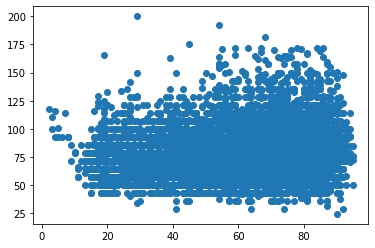

In [22]:
from matplotlib import pyplot as plt

plt.scatter(macro_data['AGE'], macro_data['ALL_C_HR'])

В возрасте нет явных выбросов, а вот пульс принимает экстремальное значение в 200, что, в прочем, все еще физически возможно. Построим то же самое, но пульс возьмем с 1го канала

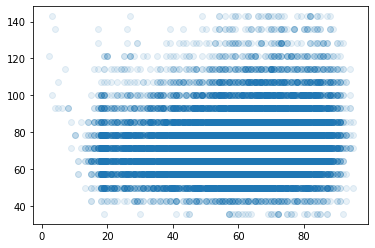

In [69]:
plt.scatter(macro_data['AGE'], macro_data['I_C_HR'], alpha =0.1)

Здесь уже есть примеры, когда пульс попросту равен 0, чего естественно быть не может. Это скорее всего связано с методикой подсчета - считается количество qrs комплексов, распознанных сегментирующей нейронной сетью, так что если сети не удается распознать qrs комплекс, скажем, из-за сильно неровной кардиограммы, пульс будет 0.

Найдем квантили для пульса с 1го канала:

In [27]:
macro_data['I_C_HR'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1]) 

0.000      0.000000
0.005     35.714286
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    107.142857
0.990    128.571429
0.995    142.857143
1.000    200.000000
Name: I_C_HR, dtype: float64

Пульс 35 выглядит критично, однако может встречаться при различных заболеваниях сердца, как и 200 ударов. Однако больше 140 и меньше 35 всего 1 процент, что можно считать выбросами из общей картины. Уберем такие строки.

In [45]:
rows_to_delete = macro_data[
    (macro_data['I_C_HR'] < macro_data['I_C_HR'].quantile(0.005)) |
    (macro_data['I_C_HR'] > macro_data['I_C_HR'].quantile(0.995)) ]
rows_to_delete

,SEX,AGE,HEIGHT,WEIGHT,ALL_C_HR,ALL_C_P_AV,ALL_C_P_DEV,ALL_C_P_A_AV,ALL_C_P_A_DEV,ALL_C_QRS_AV,...,NORM,MI,STTC,CD,HYP,NORM_PROB,MI_PROB,STTC_PROB,CD_PROB,HYP_PROB
ecg_id,,,,,,,,,,,,,,,,,,,,,
191,0,41.0,NaN,NaN,28.571429,56.754717,11.487328,0.035667,0.020926,91.580220,...,0,0,0,1,1,0,0,0,100,100
336,0,75.0,168.0,75.0,146.428571,0.000000,0.000000,0.000000,0.000000,93.482713,...,0,0,1,0,1,0,0,0,0,100
351,1,90.0,165.0,63.0,150.595238,0.000000,0.000000,0.000000,0.000000,80.565284,...,0,0,1,0,0,0,0,0,0,0
449,1,63.0,NaN,NaN,172.023810,0.000000,0.000000,0.000000,0.000000,83.656384,...,0,0,0,0,0,0,0,0,0,0
477,0,74.0,NaN,NaN,29.166667,45.994146,0.187317,0.010000,0.010000,151.311723,...,0,1,0,1,0,0,100,0,100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20935,1,82.0,NaN,NaN,148.214286,0.000000,0.000000,0.000000,0.000000,83.568924,...,0,0,1,0,0,0,0,100,0,0
21340,0,67.0,NaN,NaN,144.047619,0.000000,0.000000,0.000000,0.000000,86.340049,...,0,1,0,0,0,0,50,0,0,0
21435,0,54.0,NaN,NaN,154.761905,0.000000,0.000000,0.000000,0.000000,78.542938,...,0,0,1,0,0,0,0,100,0,0


Как видно из этой таблички, еще выбросы наблюдаются в средних длинах волн, что тоже связано с ошибками сегментации. Но для начала удалим выбросы по пульсу.

In [46]:
macro_data = macro_data.drop(rows_to_delete.index)
print(macro_data['I_C_HR'].min())
print(macro_data['I_C_HR'].quantile([0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995]))
print(macro_data['I_C_HR'].max())

35.714285714285715
0.005     42.857143
0.010     42.857143
0.050     50.000000
0.100     57.142857
0.500     71.428571
0.900     92.857143
0.950    100.000000
0.990    121.428571
0.995    128.571429
Name: I_C_HR, dtype: float64
142.85714285714286


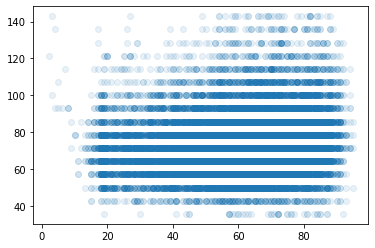

In [91]:
plt.scatter(macro_data['AGE'], macro_data['I_C_HR'], alpha =0.1)

Таким образом мы избавились от нулевого пульса. Посмотрим на длины волн.

In [66]:
macro_data['I_C_P_AV'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      0.000000
0.005      0.000000
0.010      0.000000
0.050      0.000000
0.100     56.000000
0.500     87.428571
0.900    105.333333
0.950    110.415556
0.990    118.750000
0.995    122.222222
1.000    142.400000
Name: I_C_P_AV, dtype: float64

В данном случае было бы некорректно говорить об отсутствии тех или иных волн ЭКГ как о выбросе, это может быть симптомом заболевания, тем более что в данных наблюдается 5 процентов и более таких случаев. Лучше оставить все, что связано с длинами волн, без изменений. Посмотрим лучше на вес и рост.

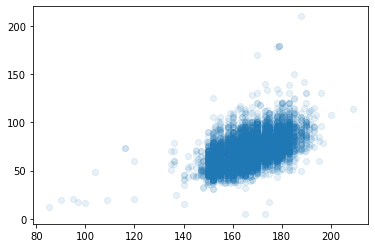

In [70]:
plt.scatter(macro_data['HEIGHT'], macro_data['WEIGHT'], alpha =0.1)

Здесь тоже наблюдаются некоторые выбросы. Рассмотрим квартили этих признаков

In [71]:
macro_data['HEIGHT'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      6.00
0.005    141.16
0.010    147.00
0.050    152.00
0.100    154.00
0.500    166.00
0.900    180.00
0.950    183.00
0.990    189.00
0.995    191.00
1.000    209.00
Name: HEIGHT, dtype: float64

Если человек ростом 209см не вызывает каких-то подозрений, то вот 6 см явная опечатка. Рассмотрим еще более мелкий квантиль.

In [83]:
macro_data['HEIGHT'].quantile([0, 0.005])

0.000      6.00
0.005    141.16
Name: HEIGHT, dtype: float64

Судя по всему, выбросов совсем мало, посмотрим на записи, в которых рост меньше 100

In [84]:
macro_data[macro_data['HEIGHT'] < 100]

,SEX,AGE,HEIGHT,WEIGHT,ALL_C_HR,ALL_C_P_AV,ALL_C_P_DEV,ALL_C_P_A_AV,ALL_C_P_A_DEV,ALL_C_QRS_AV,...,NORM,MI,STTC,CD,HYP,NORM_PROB,MI_PROB,STTC_PROB,CD_PROB,HYP_PROB
ecg_id,,,,,,,,,,,,,,,,,,,,,
6266,1,60.0,66.0,NaN,89.285714,76.776735,8.379692,0.076053,0.029476,77.818742,...,1,0,0,0,0,100,0,0,0,0
6430,1,46.0,67.0,NaN,57.142857,95.628632,16.380710,0.065979,0.033567,79.364713,...,1,0,0,0,0,100,0,0,0,0
6481,0,76.0,80.0,NaN,92.857143,77.510272,22.602065,0.072587,0.043295,88.405297,...,1,0,0,0,0,100,0,0,0,0
9384,1,79.0,6.0,NaN,71.428571,87.850463,15.653663,0.070610,0.024049,99.229646,...,0,0,0,1,0,0,0,0,100,0
10289,0,2.0,85.0,12.0,117.857143,55.405824,20.743153,0.158035,0.065320,73.504759,...,1,0,0,0,0,100,0,0,0,0
13945,0,5.0,97.0,17.0,92.857143,78.645900,15.833350,0.078942,0.027557,86.174284,...,1,0,0,0,0,100,0,0,0,0
14263,1,4.0,95.0,20.0,92.857143,76.564330,10.956473,0.067908,0.033361,78.198253,...,1,0,0,0,0,100,0,0,0,0
15207,1,86.0,6.0,NaN,64.285714,80.640867,15.804764,0.088990,0.036665,86.143210,...,0,1,0,0,0,0,15,0,0,0
15351,1,84.0,90.0,NaN,78.571429,95.299056,11.930003,0.121260,0.053678,79.320635,...,1,0,0,0,0,100,0,0,0,0


Первые 2 строчки сразу же отбрасываем, рекорд "Книги рекордов Гиннесса" - 67см. 4я строчка явно опечатка, рост 6см невозможен. С 5ой по 7ую - дети, 8ая - опечатка, остальных можно считать очень маленькими людьми. Удаляем в итоге 1, 2, 4, 8

In [85]:
macro_data = macro_data.drop([6266, 6430, 9384, 15207])
macro_data['HEIGHT'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     80.00
0.005    142.56
0.010    147.12
0.050    152.00
0.100    154.00
0.500    166.00
0.900    180.00
0.950    183.00
0.990    189.00
0.995    191.00
1.000    209.00
Name: HEIGHT, dtype: float64

Теперь рост более адекватный, попробуем то же самое с весом

In [86]:
macro_data['WEIGHT'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000      5.00
0.005     40.00
0.010     42.00
0.050     50.00
0.100     53.00
0.500     70.00
0.900     90.00
0.950     96.00
0.990    113.37
0.995    130.00
1.000    250.00
Name: WEIGHT, dtype: float64

In [87]:
macro_data[macro_data['WEIGHT'] < 40]

,SEX,AGE,HEIGHT,WEIGHT,ALL_C_HR,ALL_C_P_AV,ALL_C_P_DEV,ALL_C_P_A_AV,ALL_C_P_A_DEV,ALL_C_QRS_AV,...,NORM,MI,STTC,CD,HYP,NORM_PROB,MI_PROB,STTC_PROB,CD_PROB,HYP_PROB
ecg_id,,,,,,,,,,,,,,,,,,,,,
894,1,87.0,165.0,38.0,92.857143,76.528973,21.279234,0.058515,0.027390,76.825284,...,0,0,1,0,0,0,0,100,0,0
1214,1,64.0,161.0,38.0,107.142857,71.903238,15.436284,0.082669,0.034326,76.173415,...,1,0,0,0,0,80,0,0,0,0
1325,1,89.0,167.0,39.0,80.357143,81.500070,31.507335,0.139305,0.047471,88.076721,...,0,1,0,0,1,0,100,0,0,100
1359,1,31.0,NaN,38.0,50.000000,92.695347,14.771005,0.106354,0.044703,82.640363,...,1,0,0,1,0,100,0,0,100,0
1625,1,NaN,148.0,32.0,85.714286,78.321757,7.821527,0.119099,0.032929,106.156044,...,0,1,0,1,0,0,35,0,100,0
1657,0,12.0,152.0,39.0,85.714286,94.335617,13.862920,0.097726,0.036295,87.540090,...,1,0,0,0,0,100,0,0,0,0
1819,1,66.0,155.0,38.0,106.547619,57.555556,13.758540,0.173357,0.072530,73.653696,...,0,1,0,1,1,0,50,0,100,100
1894,1,60.0,152.0,38.0,114.285714,61.200000,13.302631,0.069800,0.025214,102.941880,...,0,1,1,0,0,0,100,100,0,0
2205,1,84.0,152.0,31.0,64.285714,0.000000,0.000000,0.000000,0.000000,153.083544,...,0,0,0,0,0,0,0,0,0,0


In [88]:
macro_data = macro_data.drop([6059, 7945])
macro_data['WEIGHT'].quantile([0, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99, 0.995, 1])

0.000     12.00
0.005     40.00
0.010     42.00
0.050     50.00
0.100     53.00
0.500     70.00
0.900     90.00
0.950     96.00
0.990    113.39
0.995    130.00
1.000    250.00
Name: WEIGHT, dtype: float64

In [89]:
macro_data[macro_data['WEIGHT'] > 150]

,SEX,AGE,HEIGHT,WEIGHT,ALL_C_HR,ALL_C_P_AV,ALL_C_P_DEV,ALL_C_P_A_AV,ALL_C_P_A_DEV,ALL_C_QRS_AV,...,NORM,MI,STTC,CD,HYP,NORM_PROB,MI_PROB,STTC_PROB,CD_PROB,HYP_PROB
ecg_id,,,,,,,,,,,,,,,,,,,,,
820,1,72.0,NaN,160.0,100.000000,52.859113,13.999397,0.109071,0.033587,101.247968,...,0,0,1,0,1,0,0,100,0,50
825,1,72.0,NaN,160.0,79.761905,54.332216,10.976455,0.060833,0.037222,100.722510,...,0,0,1,1,1,0,0,100,100,50
828,1,72.0,NaN,160.0,100.000000,49.255981,17.525826,0.033714,0.019513,97.521333,...,0,0,1,0,1,0,0,100,0,100
971,1,70.0,NaN,158.0,78.571429,83.893671,12.171395,0.077435,0.037519,81.497525,...,1,0,0,0,0,100,0,0,0,0
1753,1,61.0,NaN,164.0,57.142857,94.676288,22.145824,0.089363,0.030569,97.575031,...,0,1,0,0,0,0,15,0,0,0
2343,0,19.0,NaN,164.0,64.285714,90.795597,14.403036,0.055374,0.021252,93.013105,...,1,0,0,0,0,80,0,0,0,0
2737,1,41.0,NaN,165.0,42.857143,93.081866,10.722359,0.095536,0.036092,79.921856,...,1,0,0,0,0,80,0,0,0,0
3254,0,45.0,NaN,163.0,42.857143,94.454212,9.263903,0.071931,0.019893,85.763858,...,1,0,0,0,0,100,0,0,0,0
3387,0,50.0,188.0,210.0,71.428571,114.457534,17.116254,0.089042,0.030495,94.752186,...,0,1,0,0,0,0,35,0,0,0


Слишком худых удалили, а слишком толстых нет, т.к. даже 250кг это очень большой, но все еще реальный вес

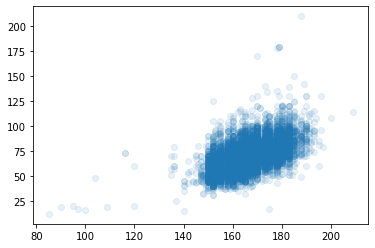

In [90]:
plt.scatter(macro_data['HEIGHT'], macro_data['WEIGHT'], alpha =0.1)

## Визуализация и описательная статистика

In [92]:
macro_data.describe()

,SEX,AGE,HEIGHT,WEIGHT,ALL_C_HR,ALL_C_P_AV,ALL_C_P_DEV,ALL_C_P_A_AV,ALL_C_P_A_DEV,ALL_C_QRS_AV,...,NORM,MI,STTC,CD,HYP,NORM_PROB,MI_PROB,STTC_PROB,CD_PROB,HYP_PROB
count,21668.000000,21580.000000,6911.000000,9362.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,...,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000
mean,0.478309,59.753568,166.800608,71.055757,72.872384,88.306564,15.840311,0.093488,0.037745,91.687293,...,0.438896,0.250554,0.238739,0.223925,0.121931,40.839256,16.570473,21.657052,22.176481,9.092210
std,0.499541,16.944841,10.216989,15.853043,15.948099,16.591384,5.055752,0.064600,0.041900,15.036101,...,0.496264,0.433342,0.426323,0.416882,0.327214,47.136694,33.880305,40.370240,41.404813,26.553495
min,0.000000,2.000000,80.000000,12.000000,31.547619,0.000000,0.000000,0.000000,0.000000,46.908657,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,50.000000,160.000000,60.000000,64.285714,82.250545,12.644414,0.073265,0.027656,83.351869,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,62.000000,166.000000,70.000000,71.428571,91.363866,15.386473,0.089280,0.034295,87.881626,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,72.000000,174.000000,80.000000,78.571429,98.564128,18.834733,0.107876,0.042789,94.070804,...,1.000000,1.000000,0.000000,0.000000,0.000000,100.000000,15.000000,0.000000,0.000000,0.000000
max,1.000000,95.000000,209.000000,250.000000,152.380952,129.005983,43.473538,2.903667,2.110547,381.973276,...,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,100.000000,100.000000,100.000000,100.000000
